К этому моменту твиты уже очищенны от повторений, от "лишних хэштегов" (#анекдот, #нашапсихология), указывающих на стандартную рассылку, не имеющую ничего общего с подходящими для исследования употреблениями, а также выделенные при помощи Twitter API твиты очищены от состоящих из одних только упоминаний и хэштегов (слова, начинающиеся на # и @, соответственно).

## Пункт 1. Объединение датасетов в один
Здесь используются два корпуса, находящихся в открытом доступе на сайте

In [1]:
import pandas as pd

вручную размеченный корпус

In [2]:
ironical = pd.read_csv('irony_corpus.csv', encoding="utf8")
ironical.shape

(1550, 3)

выделенный по хэштегам набор

In [3]:
sarcasm = pd.read_csv('sarcasm.csv', encoding="utf8")
sarcasm.shape

(437, 2)

Корпус Ю. Рубцовой

In [4]:
positive = pd.read_csv('positive.csv', encoding="utf8", delimiter=";").head(5000)
negative = pd.read_csv('negative.csv', encoding="utf8", delimiter=";").head(5000)
print(positive.shape, negative.shape)

(5000, 12) (5000, 12)


In [5]:
ironical.head()

,text,query,link
0,Амбасадоры и евангелисты там :) Виндузятники -...,это была ирония,https://twitter.com/caustikk/status/1445108219...
1,стыдпозор,это была ирония,https://twitter.com/che_nah_/status/3995794702...
2,серьезно?,это была ирония,https://twitter.com/kik_butowcki123/status/618...
3,"Какой победе, у нас вроде не война а спецопера...",это был сарказм,https://twitter.com/Draconitsa/status/15051399...
4,Человеческое днк совпадает на 80% с морским ог...,это была ирония,https://twitter.com/jbiQj5gRI809z0g/status/148...


In [6]:
positive.head(2)

,id,num,nick,text,-,-.1,-.2,-.3,-.4,-.5,-.6,-.7
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2


In [7]:
first = ironical.drop(['query',"link"] , 1)
second = positive.drop(['id',"num", "nick", "-", "-.1", "-.2","-.3","-.4","-.5","-.6","-.7"] , 1)
third = negative.drop(['id',"num", "nick", "-", "-.1", "-.2","-.3","-.4","-.5","-.6","-.7"] , 1)

In [8]:
first["target"] = 1
second["target"] = 0
third["target"] = 0

In [9]:
second.head(2)

,text,target
0,"@first_timee хоть я и школота, но поверь, у на...",0
1,"Да, все-таки он немного похож на него. Но мой ...",0


In [10]:
frames = [first, second, third, sarcasm]
df = pd.concat(frames)
df.shape

(11987, 2)

Перемешаем рандомно

In [11]:
df = df.sample(frac=1)
df.head(2)

,text,target
4779,Опять температура поднялась...\nЗавтра в больн...,0
3447,"Я была на танцах с 17-21, хотя я не чувствую ...",0


<AxesSubplot:title={'center':'Распределение классов (ирония и не ирония)'}>

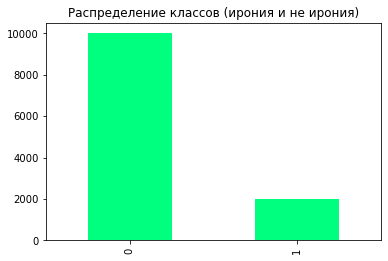

In [12]:
df["target"].value_counts().plot(kind='bar', title="Распределение классов (ирония и не ирония)", color = "springgreen")

## Пункт 2. Pre-processing текстов твитов для построения моделей на лексических features.
Фактически, обработка текстов представлена, как собственно-реализованная функция токенизаации + замена упоминаний на "@". 

In [13]:
import regex as re

In [14]:
df['text'] = df['text'].str.replace(r'@[\S]+','@')

<ipython-input-14-c3e38299ddd4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'@[\S]+','@')


In [15]:
from nltk.tokenize import TweetTokenizer # Так как оставляет хэштеги
tw = TweetTokenizer()

from pymorphy2 import MorphAnalyzer
m = MorphAnalyzer()

In [16]:
def my_tokenization(s): # Получает на вход строку
    s = s.lower() # Переводит строку в нижний регистр
    s = tw.tokenize(s) # Разбивает на токены
    new_s = []
    for i in s: # Проверка на то, что это слово или оставшееся упоминание
        if not set("ёйцукенгшщзхфывапролджэъячсмитьбю@").isdisjoint(i):
            new_s.append(m.parse(i)[0].normal_form)
    return new_s

И, наконец, разбиение данных на обучающую и тестовую выборки.

In [51]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [52]:
train_X = train["text"]
train_y = train["target"]
test_X = test["text"]
test_y = test["target"]

<AxesSubplot:title={'center':'Распределение классов в тестовой выборке'}>

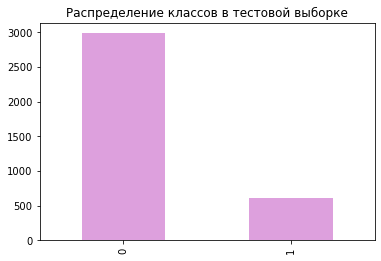

In [53]:
test_y.value_counts().plot(kind='bar', title="Распределение классов в тестовой выборке", color = "plum")

## Пункт 3. Собственно обучение моделей.
Фактически, обработка текстов представлена, как собственно-реализованная функция токенизаации + замена упоминаний на "@". 

#### Извлечение лексических признаков c помощью CountVectorizer

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
c_v = CountVectorizer(tokenizer=my_tokenization)
features_matrix = c_v.fit_transform(train_X) # И fit и transform на обчающей
test_matrix = c_v.transform(test_X) # только transform на тестовой

In [56]:
features_matrix.shape

(8390, 14759)

#### Извлечение лексических признаков c помощью TfidfVectorizer

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
tfidf = TfidfVectorizer(tokenizer=my_tokenization) 
tfidf_train = tfidf.fit_transform(train_X) 
tfidf_test = tfidf.transform(test_X) 

In [68]:
features_matrix.shape

(8390, 14759)

### 3.1. Логистическая регрессия - первый этап

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

I) По features, извлечённым при помощи CountVectorizer

In [58]:
# Обучение
model = LogisticRegression(max_iter=300)
model.fit(features_matrix, train_y)

LogisticRegression(max_iter=300)

In [59]:
# Предсказание
predictions_test = model.predict(test_matrix)

In [107]:
# Предсказание вероятностей для дальнейшей работы
model.predict_proba(features_matrix)

array([[0.83779319, 0.16220681],
       [0.99766785, 0.00233215],
       [0.93910513, 0.06089487],
       ...,
       [0.97808058, 0.02191942],
       [0.89988519, 0.10011481],
       [0.08378669, 0.91621331]])

In [60]:
# Оценка результатов
print("F1-мера на тестовой выборке", f1_score(test_y, predictions_test))
print("Точность на тестовой выборке", precision_score(test_y, predictions_test))
print("Полнота на тестовой выборке", recall_score(test_y, predictions_test))

F1-мера на тестовой выборке 0.4481236203090508
Точность на тестовой выборке 0.6904761904761905
Полнота на тестовой выборке 0.33169934640522875


Попытка без токенизации

In [102]:
# Обучение
model = LogisticRegression(max_iter=300)
model.fit(features_matrix_not, train_y)

LogisticRegression(max_iter=300)

In [103]:
# Предсказание
predictions_test_not = model.predict(test_matrix_not)

In [104]:
# Оценка результатов
print("F1-мера на тестовой выборке", f1_score(test_y, predictions_test_not))
print("Точность на тестовой выборке", precision_score(test_y, predictions_test_not))
print("Полнота на тестовой выборке", recall_score(test_y, predictions_test_not))

F1-мера на тестовой выборке 0.4481236203090508
Точность на тестовой выборке 0.6904761904761905
Полнота на тестовой выборке 0.33169934640522875


II) По features, извлечённым при помощи TfidfVectorizer

In [69]:
model = LogisticRegression(max_iter=300)
model.fit(tfidf_train, train_y)

LogisticRegression(max_iter=300)

In [70]:
predictions_test = model.predict(tfidf_test)

In [71]:
# Оценка результатов
print("F1-мера на тестовой выборке", f1_score(test_y, predictions_test))
print("Точность на тестовой выборке", precision_score(test_y, predictions_test))
print("Полнота на тестовой выборке", recall_score(test_y, predictions_test))

F1-мера на тестовой выборке 0.2697547683923706
Точность на тестовой выборке 0.8114754098360656
Полнота на тестовой выборке 0.16176470588235295


In [108]:
tfidf_prob = model.predict_proba(features_matrix)

In [106]:
model.coef_

array([[-0.08265555, -0.13295585, -0.11809901, ..., -0.07525952,
        -0.09542578, -0.07797849]])

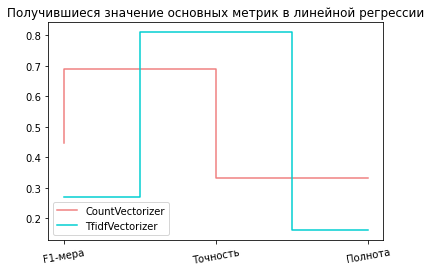

In [85]:
#График лог рег
import matplotlib.pyplot as plt

x = ["F1-мера","Точность","Полнота"]
list_CV = [0.448, 0.690, 0.332]
list_TF_IDF = [0.270, 0.811, 0.162]

plt.step(x, list_CV, label='CountVectorizer', color = "lightcoral")
plt.xticks(rotation=10)

plt.step(x, list_TF_IDF, where='mid', label='TfidfVectorizer', color = "darkturquoise")
plt.xticks(rotation=10)

plt.legend()
plt.title('Получившиеся значение основных метрик в линейной регрессии')
plt.show()

### 3. Не-логистическая регрессия

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
from sklearn.model_selection import cross_val_score

In [90]:
clf = DecisionTreeClassifier(random_state=0)

In [ ]:
cross_val_score(clf, iris.data, iris.target, cv=10)

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


In [ ]:
BC = BaggingClassifier(base_estimator=SVC(),
                       n_estimators=10, random_state=0).fit(tfidf_train, train_y)
predictions = BC.predict(tfidf_test)

In [ ]:
# Оценка результатов
print("F1-мера на тестовой выборке", f1_score(test_y, predictions))
print("Точность на тестовой выборке", precision_score(test_y, predictions))
print("Полнота на тестовой выборке", recall_score(test_y, predictions))

In [100]:
BC_tfidf = BaggingClassifier(base_estimator=SVC(),
                       n_estimators=10, random_state=0).fit(tfidf_train, train_y)
predictions_tfidf = BC.predict(tfidf_test)

In [101]:
# Оценка результатов
print("F1-мера на тестовой выборке", f1_score(test_y, predictions_tfidf))
print("Точность на тестовой выборке", precision_score(test_y, predictions_tfidf))
print("Полнота на тестовой выборке", recall_score(test_y, predictions_tfidf))

F1-мера на тестовой выборке 0.23446327683615814
Точность на тестовой выборке 0.8645833333333334
Полнота на тестовой выборке 0.13562091503267973


In [ ]:
BC_tfidf = BaggingClassifier(base_estimator=SVC(),
                       n_estimators=10, random_state=0).fit(tfidf_train, train_y)
predictions_tfidf = BC.predict(tfidf_test)